## Customer segementation based on their buying pattern using k means clustering

In [1]:
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 150)
# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (12,8) #figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()



In [2]:
root = '/Users/divyamittal/Desktop/Project/InstaCart/Sample/'

aisles = pd.read_csv(root +'aisles.csv')
departments = pd.read_csv(root +'departments.csv')
orders = pd.read_csv(root +'orders.csv')
order_products_prior = pd.read_csv(root +'order_products__prior.csv')
order_products_train = pd.read_csv(root +'order_products__train.csv')
products = pd.read_csv(root +'products.csv')


In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
aisles.shape

(134, 2)

In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
departments.shape

(21, 2)

In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
products.head()
products.shape

(49688, 4)

As it can be observed from the data that a particular product belongs to a particluar aisle and department. When we checked the data shape, it is observed that the products are classified into 21 departments which is further classified into 134 aisles.
As the data provide is already segregated into prior, training and testing dat. Lets explore dividing the data considering prior and training data.

In [11]:
# As the data is divided into prios and training, lets merge the data and explore further into it.
order_prior=order_products_prior[['order_id', 'product_id']]
print(order_prior.shape)
order_train=order_products_train[['order_id', 'product_id']]
print(order_train.shape)
final_order=pd.concat([order_prior, order_train])
print(final_order.shape)
final_order.head()


(32434489, 2)
(1384617, 2)
(33819106, 2)


,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


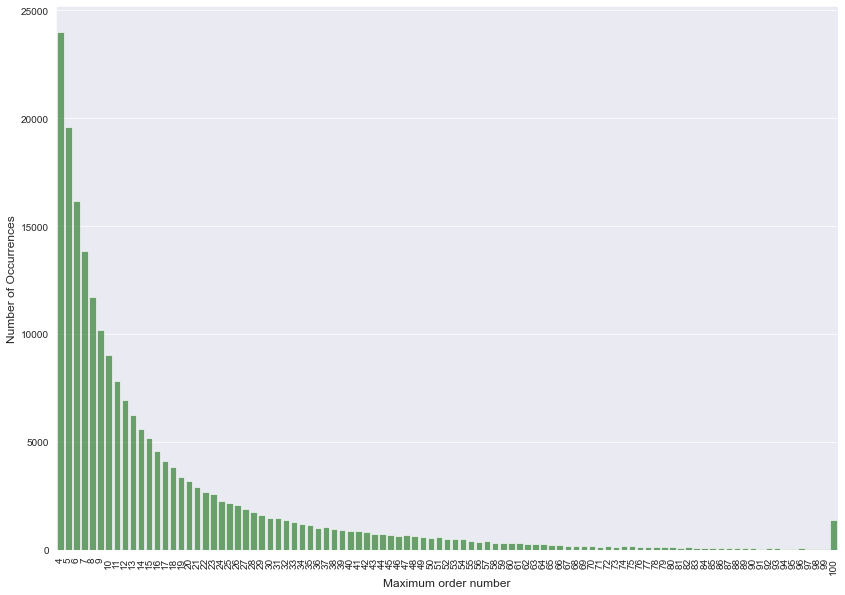

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [12]:
# As the data is divided based on user buying pattern, it is necesaary to understand how many orders every user has placed till now.
user_orders_by_order_number=orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
user_orders = user_orders_by_order_number.order_number.value_counts()
pie, ax = plt.subplots(figsize=[14,10])
#plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
sns.barplot(user_orders.index, user_orders.values, alpha=0.6, color='green')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()
user_orders_by_order_number.head()

From this graph, it can be inferred that the maximum order placed by the users are 4. It can be inferred from the dataset that instacart   is not able to hold the customers and maximum buyers has ordered just four items and left the store.
We will be clustering our users based on how many orders they have placed. As there are maximum users who have placed orders less than 10. We will try to find whether they are ordering any common product due to which it is happening.
We will also segregate the frequent users by considering users who placed orders more than 20.

In [13]:
user_product_more_than_20=user_orders_by_order_number[user_orders_by_order_number['order_number']>20]
user_product_less_than_5=user_orders_by_order_number[user_orders_by_order_number['order_number']<10]
user_product_less_than_5

,user_id,order_number
3,4,6
4,5,5
5,6,4
7,8,4
8,9,4
...,...,...
206195,206196,5
206197,206198,8
206202,206203,6
206203,206204,5


In [14]:
user_product_more_than_20.sort_values('order_number')


,user_id,order_number
6,7,21
77256,77257,21
77216,77217,21
179507,179508,21
77063,77064,21
...,...,...
17697,17698,100
37085,37086,100
17741,17742,100
144971,144972,100


In [15]:
user_product_less_than_5.sort_values('order_number')

,user_id,order_number
103528,103529,4
96237,96238,4
96239,96240,4
96244,96245,4
96254,96255,4
...,...,...
189589,189590,9
94985,94986,9
94994,94995,9
35202,35203,9


In [16]:
merged_order_product = final_order.merge(products,on='product_id')
merged_order_product

,order_id,product_id,product_name,aisle_id,department_id
0,2,33120,Organic Egg Whites,86,16
1,26,33120,Organic Egg Whites,86,16
2,120,33120,Organic Egg Whites,86,16
3,327,33120,Organic Egg Whites,86,16
4,390,33120,Organic Egg Whites,86,16
...,...,...,...,...,...
33819101,2269288,27499,Non-Dairy Coconut Seven Layer Bar,100,21
33819102,2507248,27499,Non-Dairy Coconut Seven Layer Bar,100,21
33819103,2271346,37703,Ultra Sun Blossom Liquid 90 loads Fabric Enhan...,75,17
33819104,3004244,43725,Sweetart Jelly Beans,100,21


In [17]:
#check count of products in every aisle and concatenate user based on their order id
order_per_aisle = merged_order_product[['order_id','aisle_id']]
order_per_aisle['new_aisle_id'] = order_per_aisle['aisle_id']
order_per_aisle = order_per_aisle.groupby(['order_id','aisle_id']).agg({'new_aisle_id': 'count'}).reset_index()
order_per_aisle.rename(columns={"new_aisle_id": "product_count"}, inplace=True)
order_per_aisle.head()

,order_id,aisle_id,product_count
0,1,21,1
1,1,24,2
2,1,83,2
3,1,95,1
4,1,108,1


In [18]:
aisle_products = merged_order_product.groupby('aisle_id').agg({'product_id': 'count'}).reset_index()
aisle_products = aisle_products.sort_values('product_id', ascending=False)
aisle_products = aisle_products.merge(aisles,on='aisle_id')
aisle_products.rename(columns={"product_id": "total_products_purchased"}, inplace=True)
aisle_products.head()


,aisle_id,total_products_purchased,aisle
0,24,3792661,fresh fruits
1,83,3568630,fresh vegetables
2,123,1843806,packaged vegetables fruits
3,120,1507583,yogurt
4,21,1021462,packaged cheese


In [19]:
aisle_products['percentage'] = aisle_products['total_products_purchased']/aisle_products.total_products_purchased.sum()
aisle_products

,aisle_id,total_products_purchased,aisle,percentage
0,24,3792661,fresh fruits,0.112146
1,83,3568630,fresh vegetables,0.105521
2,123,1843806,packaged vegetables fruits,0.054520
3,120,1507583,yogurt,0.044578
4,21,1021462,packaged cheese,0.030204
5,84,923659,milk,0.027312
6,115,878150,water seltzer sparkling water,0.025966
7,107,753739,chips pretzels,0.022287
8,91,664493,soy lactosefree,0.019648
9,112,608469,bread,0.017992


In [20]:
order_user_aisle = order_per_aisle.merge(orders[['order_id','user_id']], on='order_id')
order_user_aisle

,order_id,aisle_id,product_count,user_id
0,1,21,1,112108
1,1,24,2,112108
2,1,83,2,112108
3,1,95,1,112108
4,1,108,1,112108
...,...,...,...,...
24329217,3421083,52,1,25247
24329218,3421083,74,1,25247
24329219,3421083,78,1,25247
24329220,3421083,92,4,25247


In [21]:
user_aisle_id = order_user_aisle[['user_id','aisle_id','product_count']]
user_aisle_count = user_aisle_id.groupby(['user_id','aisle_id']).agg({'product_count': 'sum'}).reset_index()
user_aisle_count

,user_id,aisle_id,product_count
0,1,21,9
1,1,23,13
2,1,24,5
3,1,45,2
4,1,53,3
...,...,...,...
5919835,206209,120,3
5919836,206209,121,7
5919837,206209,123,5
5919838,206209,130,3


In [22]:
# user_aisle_count right join user_order_count_annual 
user_aisle_order_more_than_20 = user_aisle_count.merge(user_product_more_than_20, how='right',on='user_id')
user_aisle_order_more_than_20

,user_id,aisle_id,product_count,order_number
0,7,1,1,21
1,7,13,2,21
2,7,16,1,21
3,7,17,3,21
4,7,21,5,21
...,...,...,...,...
2174152,206208,121,13,50
2174153,206208,123,71,50
2174154,206208,128,7,50
2174155,206208,130,2,50


In [23]:
# less than 5 
user_product_less_than_5 = user_aisle_count.merge(user_product_less_than_5, how='right',on='user_id')
user_product_less_than_5

,user_id,aisle_id,product_count,order_number
0,4,24,2,6
1,4,28,1,6
2,4,31,1,6
3,4,38,3,6
4,4,67,2,6
...,...,...,...,...
1913310,206205,100,2,4
1913311,206205,112,2,4
1913312,206205,116,2,4
1913313,206205,120,9,4


In [24]:

user_aisle_order_more_than_20['total_prod_count_for_20'] = user_aisle_order_more_than_20['product_count']*user_aisle_order_more_than_20['order_number']
user_aisle_order_more_than_20

,user_id,aisle_id,product_count,order_number,total_prod_count_for_20
0,7,1,1,21,21
1,7,13,2,21,42
2,7,16,1,21,21
3,7,17,3,21,63
4,7,21,5,21,105
...,...,...,...,...,...
2174152,206208,121,13,50,650
2174153,206208,123,71,50,3550
2174154,206208,128,7,50,350
2174155,206208,130,2,50,100


In [25]:
user_product_less_than_5['total_prod_count_for_5'] = user_product_less_than_5['product_count']*user_product_less_than_5['order_number']
user_product_less_than_5

,user_id,aisle_id,product_count,order_number,total_prod_count_for_5
0,4,24,2,6,12
1,4,28,1,6,6
2,4,31,1,6,6
3,4,38,3,6,18
4,4,67,2,6,12
...,...,...,...,...,...
1913310,206205,100,2,4,8
1913311,206205,112,2,4,8
1913312,206205,116,2,4,8
1913313,206205,120,9,4,36


In [26]:
aisle_user = user_aisle_order_more_than_20[['aisle_id','user_id','total_prod_count_for_20']]
aisle_user = aisle_user.groupby(['aisle_id']).agg({'user_id':'count','total_prod_count_for_20': 'sum'}).reset_index()
aisle_user.rename(columns={"user_id": 'user_count'}, inplace=True)
aisle_user = aisle_user.sort_values('user_count', ascending=False)
aisle_user = aisle_user.merge(aisles, how='left', on='aisle_id')
total_user_count = 50731 # from previous step, total count of customers with more than 25 tx
aisle_user['user_percent'] = aisle_user['user_count'] / total_user_count
total_prod_count = sum(aisle_user['total_prod_count_for_20'])
aisle_user['prod_percent'] = aisle_user['total_prod_count_for_20'] / total_prod_count
aisle_user

,aisle_id,user_count,total_prod_count_for_20,aisle,user_percent,prod_percent
0,24,48543,118835021,fresh fruits,0.956871,0.122160
1,123,46504,54300734,packaged vegetables fruits,0.916678,0.055820
2,83,44185,102794955,fresh vegetables,0.870966,0.105671
3,21,41719,28998284,packaged cheese,0.822357,0.029810
4,120,40095,46841449,yogurt,0.790345,0.048152
5,107,37761,20951568,chips pretzels,0.744338,0.021538
6,84,36580,30462771,milk,0.721058,0.031315
7,116,35635,14935388,frozen produce,0.702430,0.015353
8,112,34955,18096708,bread,0.689026,0.018603
9,17,34336,9778161,baking ingredients,0.676825,0.010052


In [27]:
aisle_user_less_than_5 = user_product_less_than_5[['aisle_id','user_id','total_prod_count_for_5']]
aisle_user_less_than_5 = aisle_user_less_than_5.groupby(['aisle_id']).agg({'user_id':'count','total_prod_count_for_5': 'sum'}).reset_index()
aisle_user_less_than_5.rename(columns={"user_id": 'user_count'}, inplace=True)
aisle_user_less_than_5 = aisle_user_less_than_5.sort_values('user_count', ascending=False)
aisle_user_less_than_5 = aisle_user_less_than_5.merge(aisles, how='left', on='aisle_id')
total_user_count = 381895 # from previous step, total count of customers with more than 25 tx
aisle_user_less_than_5['user_percent'] = aisle_user_less_than_5['user_count'] / total_user_count
total_prod_count = sum(aisle_user_less_than_5['total_prod_count_for_5'])
aisle_user_less_than_5['prod_percent'] = aisle_user_less_than_5['total_prod_count_for_5'] / total_prod_count
aisle_user_less_than_5

,aisle_id,user_count,total_prod_count_for_5,aisle,user_percent,prod_percent
0,24,76567,3422507,fresh fruits,0.200492,0.099418
1,83,68295,3633848,fresh vegetables,0.178832,0.105557
2,123,66038,1813055,packaged vegetables fruits,0.172922,0.052666
3,21,51857,1045036,packaged cheese,0.135789,0.030357
4,120,47737,1374217,yogurt,0.125000,0.039919
5,107,41293,791645,chips pretzels,0.108127,0.022996
6,84,41152,777588,milk,0.107757,0.022588
7,112,38311,603029,bread,0.100318,0.017517
8,115,37673,859956,water seltzer sparkling water,0.098648,0.024980
9,91,35310,632271,soy lactosefree,0.092460,0.018366


In [28]:
new_user_aisle_order_more_than_20 = user_aisle_order_more_than_20.merge(aisles, how='inner', on='aisle_id')
new_user_aisle_order_more_than_20 = new_user_aisle_order_more_than_20.groupby(['user_id','aisle_id']).agg({'product_count':'sum','order_number':'sum','total_prod_count_for_20': 'sum'}).reset_index()
new_user_aisle_order_more_than_20

,user_id,aisle_id,product_count,order_number,total_prod_count_for_20
0,7,1,1,21,21
1,7,13,2,21,42
2,7,16,1,21,21
3,7,17,3,21,63
4,7,21,5,21,105
...,...,...,...,...,...
2174152,206208,121,13,50,650
2174153,206208,123,71,50,3550
2174154,206208,128,7,50,350
2174155,206208,130,2,50,100


In [29]:
new_user_aisle_order_less_than_5 = user_product_less_than_5.merge(aisles, how='inner', on='aisle_id')
user_product_less_than_5 = user_product_less_than_5.groupby(['user_id','aisle_id']).agg({'product_count':'sum','order_number':'sum','total_prod_count_for_5': 'sum'}).reset_index()
new_user_aisle_order_less_than_5.sort_values('product_count')

,user_id,aisle_id,product_count,order_number,total_prod_count_for_5,aisle
956657,96150,53,1,7,7,cream
683145,128717,86,1,6,6,eggs
683146,128723,86,1,4,4,eggs
683147,128746,86,1,4,4,eggs
1361805,62897,116,1,8,8,frozen produce
...,...,...,...,...,...,...
64490,173753,24,102,9,918,fresh fruits
311742,35537,115,103,7,721,water seltzer sparkling water
118748,89597,38,112,7,784,frozen meals
1127000,54348,92,112,8,896,baby food formula


In [30]:
#TO DO : then aisle is dropped i vl see what to drop later

In [31]:
aisle_user = new_user_aisle_order_more_than_20[['aisle_id','user_id','total_prod_count_for_20']]
aisle_user = aisle_user.groupby(['aisle_id']).agg({'user_id':'count','total_prod_count_for_20': 'sum'}).reset_index()
aisle_user.rename(columns={"user_id": 'user_count'}, inplace=True)
aisle_user = aisle_user.sort_values('user_count', ascending=False)
aisle_user = aisle_user.merge(aisles, how='left', on='aisle_id')
total_user_count = 50731 # from previous step, total count of customers with more than 24 tx
aisle_user['user_percent'] = aisle_user['user_count'] / total_user_count
total_prod_count = sum(aisle_user['total_prod_count_for_20'])
aisle_user['prod_percent'] = aisle_user['total_prod_count_for_20'] / total_prod_count
aisle_user = aisle_user[['aisle_id', 'user_count', 'total_prod_count_for_20','aisle','user_percent','prod_percent']]
aisle_user.drop_duplicates(inplace=True)
aisle_user

,aisle_id,user_count,total_prod_count_for_20,aisle,user_percent,prod_percent
0,24,48543,118835021,fresh fruits,0.956871,0.122160
1,123,46504,54300734,packaged vegetables fruits,0.916678,0.055820
2,83,44185,102794955,fresh vegetables,0.870966,0.105671
3,21,41719,28998284,packaged cheese,0.822357,0.029810
4,120,40095,46841449,yogurt,0.790345,0.048152
5,107,37761,20951568,chips pretzels,0.744338,0.021538
6,84,36580,30462771,milk,0.721058,0.031315
7,116,35635,14935388,frozen produce,0.702430,0.015353
8,112,34955,18096708,bread,0.689026,0.018603
9,17,34336,9778161,baking ingredients,0.676825,0.010052


In [32]:
aisle_user_less_than_5 = new_user_aisle_order_less_than_5[['aisle_id','user_id','total_prod_count_for_5']]
aisle_user_less_than_5 = aisle_user_less_than_5.groupby(['aisle_id']).agg({'user_id':'count','total_prod_count_for_5': 'sum'}).reset_index()
aisle_user_less_than_5.rename(columns={"user_id": 'user_count'}, inplace=True)
aisle_user_less_than_5 = aisle_user_less_than_5.sort_values('user_count', ascending=False)
aisle_user_less_than_5 = aisle_user_less_than_5.merge(aisles, how='left', on='aisle_id')
total_user_count = 381895 # from previous step, total count of customers with more than 24 tx
aisle_user_less_than_5['user_percent'] = aisle_user_less_than_5['user_count'] / total_user_count
total_prod_count = sum(aisle_user_less_than_5['total_prod_count_for_5'])
aisle_user_less_than_5['prod_percent'] = aisle_user_less_than_5['total_prod_count_for_5'] / total_prod_count
aisle_user_less_than_5 = aisle_user_less_than_5[['aisle_id', 'user_count', 'total_prod_count_for_5','aisle','user_percent','prod_percent']]
aisle_user_less_than_5.drop_duplicates(inplace=True)
aisle_user_less_than_5

,aisle_id,user_count,total_prod_count_for_5,aisle,user_percent,prod_percent
0,24,76567,3422507,fresh fruits,0.200492,0.099418
1,83,68295,3633848,fresh vegetables,0.178832,0.105557
2,123,66038,1813055,packaged vegetables fruits,0.172922,0.052666
3,21,51857,1045036,packaged cheese,0.135789,0.030357
4,120,47737,1374217,yogurt,0.125000,0.039919
5,107,41293,791645,chips pretzels,0.108127,0.022996
6,84,41152,777588,milk,0.107757,0.022588
7,112,38311,603029,bread,0.100318,0.017517
8,115,37673,859956,water seltzer sparkling water,0.098648,0.024980
9,91,35310,632271,soy lactosefree,0.092460,0.018366


In [33]:
aisle_user[['aisle','user_percent']]

,aisle,user_percent
0,fresh fruits,0.956871
1,packaged vegetables fruits,0.916678
2,fresh vegetables,0.870966
3,packaged cheese,0.822357
4,yogurt,0.790345
5,chips pretzels,0.744338
6,milk,0.721058
7,frozen produce,0.702430
8,bread,0.689026
9,baking ingredients,0.676825


In [34]:
aisle_user_less_than_5[['aisle','user_percent']]

,aisle,user_percent
0,fresh fruits,0.200492
1,fresh vegetables,0.178832
2,packaged vegetables fruits,0.172922
3,packaged cheese,0.135789
4,yogurt,0.125000
5,chips pretzels,0.108127
6,milk,0.107757
7,bread,0.100318
8,water seltzer sparkling water,0.098648
9,soy lactosefree,0.092460


In [35]:
#non_essential_aisle = aisle_user.loc[(aisle_user['user_percent'] < 0.6) & (aisle_user['new_aisle_ID'] != 55), 'new_aisle_ID']
non_essential_aisle = aisle_user.loc[(aisle_user['user_percent'] < 0.7), 'aisle_id']
non_essential_aisle
user_aisle_order_count_annual_nesse = new_user_aisle_order_more_than_20.merge(non_essential_aisle, how='inner', on='aisle_id')
user_aisle_order_count_annual_nesse

,user_id,aisle_id,product_count,order_number,total_prod_count_for_20
0,7,1,1,21,21
1,101,1,3,21,63
2,110,1,1,21,21
3,140,1,3,77,231
4,155,1,17,23,391
...,...,...,...,...,...
1843130,205510,113,1,51,51
1843131,205558,113,2,34,68
1843132,205780,113,9,29,261
1843133,205868,113,10,34,340


In [36]:
#non_essential_aisle = aisle_user.loc[(aisle_user['user_percent'] < 0.6) & (aisle_user['new_aisle_ID'] != 55), 'new_aisle_ID']
non_essential_aisle = aisle_user_less_than_5.loc[(aisle_user_less_than_5['user_percent'] < 0.8), 'aisle_id']
non_essential_aisle
aisle_user_less_than_5_final = new_user_aisle_order_less_than_5.merge(non_essential_aisle, how='inner', on='aisle_id')
aisle_user_less_than_5_final

,user_id,aisle_id,product_count,order_number,total_prod_count_for_5,aisle
0,4,24,2,6,12,fresh fruits
1,5,24,5,5,25,fresh fruits
2,8,24,3,4,12,fresh fruits
3,9,24,5,4,20,fresh fruits
4,10,24,14,6,84,fresh fruits
...,...,...,...,...,...,...
1913310,203269,113,1,5,5,frozen juice
1913311,203593,113,1,6,6,frozen juice
1913312,204059,113,1,8,8,frozen juice
1913313,204392,113,2,6,12,frozen juice


In [37]:
user_aisle_order_count_annual_nesse['avg'] = user_aisle_order_count_annual_nesse['product_count']/user_aisle_order_count_annual_nesse['order_number']
user_aisle_avgCount_annual = user_aisle_order_count_annual_nesse[['user_id','aisle_id','avg']]
user_aisle_avgCount_annual

,user_id,aisle_id,avg
0,7,1,0.047619
1,101,1,0.142857
2,110,1,0.047619
3,140,1,0.038961
4,155,1,0.739130
...,...,...,...
1843130,205510,113,0.019608
1843131,205558,113,0.058824
1843132,205780,113,0.310345
1843133,205868,113,0.294118


In [38]:
aisle_user_less_than_5_final['avg'] = aisle_user_less_than_5_final['product_count']/aisle_user_less_than_5_final['order_number']
aisle_user_less_than_5_avg = aisle_user_less_than_5_final[['user_id','aisle_id','avg']]
aisle_user_less_than_5_avg.sort_values('avg')

,user_id,aisle_id,avg
273875,36688,112,0.111111
1817931,77425,133,0.111111
201912,31199,77,0.111111
1175655,139594,106,0.111111
388959,178868,16,0.111111
...,...,...,...
1127000,54348,92,14.000000
311742,35537,115,14.714286
1129423,122250,92,15.800000
118748,89597,38,16.000000


In [39]:
data = pd.pivot_table(user_aisle_avgCount_annual, values='avg', index=['user_id'],columns=['aisle_id'], aggfunc=np.sum, fill_value=0)
data.reset_index(inplace=True)
# index match
index_match = data['user_id']
#index_match
data.set_index('user_id', inplace=True)

data

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.391304,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
17,0.000000,0.000000,0.000000,0.121951,0.097561,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.048780,0.000000,0.0,0.0,0.0
21,0.000000,0.000000,0.235294,0.029412,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
27,0.000000,0.024390,0.560976,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206200,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.083333,0.041667,0.0,0.0,0.0
206201,0.000000,0.212121,0.000000,0.181818,0.060606,0.000000,0.00,0.0,0.090909,0.0,...,0.000000,0.0,0.0,0.060606,0.151515,0.121212,0.303030,0.0,0.0,0.0
206202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.043478,0.000000,0.0,0.0,0.0


In [40]:
data_less_than_5 = pd.pivot_table(aisle_user_less_than_5_avg, values='avg', index=['user_id'],columns=['aisle_id'], aggfunc=np.sum, fill_value=0)
data_less_than_5.reset_index(inplace=True)
# index match
index_match_less_than_5 = data_less_than_5['user_id']
#index_match
data_less_than_5.set_index('user_id', inplace=True)

data_less_than_5

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.000,0.166667,0.000000,0.00,0.00,0.0,0.000,0.166667
5,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.000,0.000000,0.000000,0.00,0.00,0.0,0.000,0.000000
6,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.000,0.000000,0.000000,0.00,0.00,0.0,0.000,0.000000
8,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.000,0.250000,0.000000,0.00,0.00,0.0,0.000,0.000000
9,0.0,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.000,0.000000,0.000000,0.25,0.00,0.0,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206196,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.400,0.0,...,0.0,0.0,0.000,0.000000,0.000000,0.00,0.60,0.0,0.000,0.000000
206198,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.125,0.0,...,0.0,0.0,0.125,0.000000,0.000000,0.00,0.75,0.0,0.125,0.000000
206203,0.0,0.0,1.333333,0.0,0.166667,0.0,0.166667,0.0,0.000,0.0,...,0.0,0.0,0.000,0.333333,0.666667,0.00,0.00,0.0,0.000,0.000000


In [41]:
# principal component analysis for dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_for_less_than_5_products = pca.fit_transform(data_less_than_5)
np.sum(pca.explained_variance_ratio_)

0.9089681077857662

In [42]:
pca_50_dataset = pd.DataFrame(pca_for_less_than_5_products)
pca_50_dataset
pca_50_dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,...,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04
mean,2.494720e-16,1.439880e-16,-1.915022e-16,1.599737e-17,1.036300e-16,-8.894017e-17,-6.343862e-17,4.184571e-17,1.024120e-16,3.004594e-18,...,1.842712e-17,-7.805374e-18,8.385015e-18,-4.988117e-17,-3.607048e-17,-7.349138e-18,-6.835320e-17,3.701841e-17,4.601918e-17,4.670841e-18
std,1.400127e+00,7.637651e-01,6.090395e-01,5.054032e-01,4.486688e-01,4.383995e-01,4.228270e-01,4.096979e-01,3.659492e-01,3.401728e-01,...,1.729305e-01,1.688849e-01,1.663847e-01,1.635621e-01,1.620390e-01,1.596882e-01,1.575342e-01,1.561150e-01,1.540453e-01,1.512903e-01
min,-1.644550e+00,-6.296321e+00,-7.015914e+00,-7.048085e+00,-3.827347e+00,-6.119149e+00,-6.916233e+00,-3.713754e+00,-2.890661e+00,-7.193349e+00,...,-2.135592e+00,-2.741300e+00,-2.771914e+00,-1.023461e+00,-1.666267e+00,-1.175027e+00,-1.336565e+00,-1.584203e+00,-1.147937e+00,-6.645817e-01
25%,-1.074425e+00,-3.981196e-01,-3.156987e-01,-2.264168e-01,-2.167065e-01,-2.283957e-01,-1.159489e-01,-1.808344e-01,-1.839106e-01,-1.176906e-01,...,-5.328140e-02,-5.433787e-02,-6.196816e-02,-8.004865e-02,-7.242539e-02,-5.343811e-02,-7.604288e-02,-5.844284e-02,-7.797649e-02,-4.333309e-02
50%,-3.668297e-01,-9.918383e-02,-5.918369e-02,4.825386e-02,-1.419174e-02,-6.404250e-02,-2.612959e-02,-1.818140e-02,-1.113350e-02,4.217690e-02,...,5.849627e-03,-8.968039e-03,-1.063053e-03,-1.642638e-02,-4.199409e-03,-1.553900e-02,-1.514876e-02,3.722151e-04,-7.444673e-03,-1.705013e-02
75%,6.956462e-01,3.677921e-01,2.709346e-01,2.457563e-01,2.154270e-01,1.927032e-01,5.987333e-02,1.237665e-01,1.552772e-01,1.576090e-01,...,7.074472e-02,3.656651e-02,5.708768e-02,5.741650e-02,6.458343e-02,2.015839e-02,5.731493e-02,5.369910e-02,6.784485e-02,1.298493e-02
max,1.172779e+01,8.174563e+00,9.393282e+00,7.778705e+00,1.054634e+01,9.629200e+00,1.305907e+01,9.737055e+00,1.369278e+01,1.044147e+01,...,2.609758e+00,3.142400e+00,2.813838e+00,2.540878e+00,2.025097e+00,5.617393e+00,2.492055e+00,1.916935e+00,1.819624e+00,7.207371e+00


In [43]:
pca = PCA(n_components=46)
pca_46 = pca.fit_transform(data)
np.sum(pca.explained_variance_ratio_)

0.8907339161509261

In [44]:
pca_46_dataset = pd.DataFrame(pca_46) #check for variance and try to normalize it if possible
pca_46_dataset
pca_46_dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
count,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,...,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04,5.068200e+04
mean,-7.853182e-18,-5.741475e-17,2.873366e-17,4.073578e-17,-1.026478e-16,-2.568439e-17,-4.374014e-17,-2.345002e-18,1.460998e-17,3.693186e-17,...,-1.318256e-17,1.221967e-17,-3.617447e-17,2.062781e-17,-6.026797e-18,-4.063565e-18,7.962710e-18,2.333200e-17,2.905622e-17,-2.858690e-19
std,5.130807e-01,4.743275e-01,4.172886e-01,3.603141e-01,3.366678e-01,3.252754e-01,2.981708e-01,2.872292e-01,2.689434e-01,2.471784e-01,...,1.282570e-01,1.244589e-01,1.230024e-01,1.200238e-01,1.168813e-01,1.147612e-01,1.119789e-01,1.096562e-01,1.085270e-01,1.034834e-01
min,-1.089220e+00,-5.493113e+00,-5.464044e+00,-3.030800e+00,-6.295360e+00,-1.761836e+00,-2.350774e+00,-2.311831e+00,-2.703143e+00,-2.656323e+00,...,-1.134601e+00,-7.487908e-01,-1.046443e+00,-1.551331e+00,-1.002219e+00,-1.472089e+00,-1.081450e+00,-7.087841e-01,-1.074252e+00,-9.133859e-01
25%,-3.263416e-01,-1.460484e-01,-1.885163e-01,-1.651026e-01,-7.272331e-02,-1.756045e-01,-1.420552e-01,-1.515204e-01,-1.575289e-01,-1.251337e-01,...,-5.151878e-02,-6.280651e-02,-5.014982e-02,-4.841073e-02,-4.678995e-02,-2.959902e-02,-4.172535e-02,-4.933921e-02,-4.227966e-02,-5.284533e-02
50%,-1.170896e-01,3.553558e-02,3.671508e-03,1.955244e-03,2.448539e-02,-1.179653e-02,8.051788e-03,-6.530605e-02,-3.642569e-02,-3.266879e-02,...,-1.000104e-03,-1.588091e-02,-4.194785e-03,-1.652911e-02,-1.319993e-03,2.081730e-03,-2.194393e-04,-1.165161e-02,-4.334864e-03,-9.092174e-03
75%,1.869387e-01,1.206699e-01,2.100028e-01,1.509481e-01,1.202706e-01,1.454264e-01,1.353323e-01,7.741080e-02,1.278674e-01,8.563811e-02,...,4.827844e-02,3.878890e-02,4.880993e-02,1.881734e-02,4.754725e-02,3.554463e-02,3.437300e-02,3.229448e-02,4.158414e-02,3.919260e-02
max,8.301679e+00,1.069024e+01,7.326889e+00,1.348296e+01,9.232492e+00,6.865169e+00,6.424860e+00,4.568735e+00,3.319838e+00,5.646850e+00,...,3.260262e+00,2.116536e+00,1.068374e+00,3.944771e+00,1.481628e+00,1.492419e+00,1.908265e+00,1.730355e+00,1.222230e+00,1.104368e+00


In [45]:
# principal component analysis for dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca_40 = pca.fit_transform(data)
np.sum(pca.explained_variance_ratio_)

0.8615685924883979

In [46]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [47]:
def plotElbowGraphForPCA(pcaModel):   
    df = pd.DataFrame(columns = ['cluster','inertia'])
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(pcaModel)
        df = df.append({'cluster':n, 'inertia': kmeans.inertia_}, ignore_index=True)
    plt.plot(df['cluster'],df['inertia'])
    plt.xticks(np.arange(1, 10)) #change the value of it
    plt.xlabel('cluster count')
    plt.ylabel('inertia')
    return kmeans , 

(KMeans(n_clusters=9, random_state=42),)

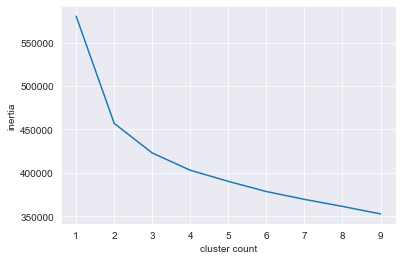

In [48]:
plotElbowGraphForPCA(pca_50_dataset)

In [49]:
from yellowbrick.cluster import InterclusterDistance
def CalculateCluster(model, n_cluster):
    modelKmean = KMeans(n_clusters=n_cluster, random_state=42)
    visualizer = InterclusterDistance(modelKmean)
    visualizer.fit(model)
    visualizer.show()

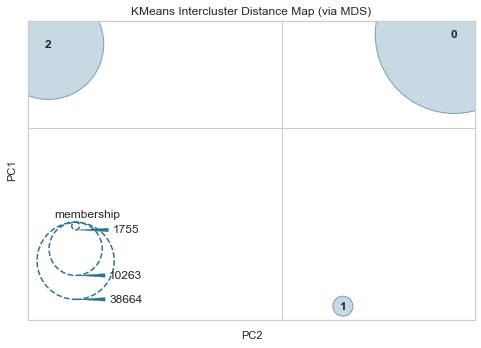

In [50]:
CalculateCluster(pca_46_dataset,3)

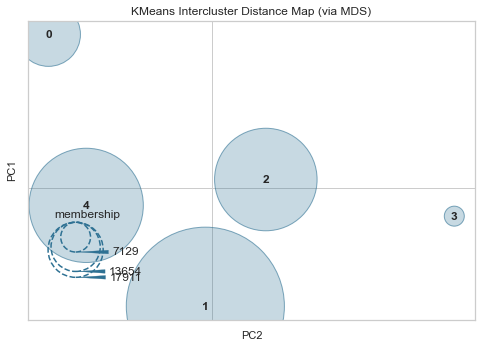

In [51]:
CalculateCluster(pca_50_dataset,5)

In [1]:
def createTemplateForCSV(n_clusters,dataset,user_info,name):
    modelForCluster=KMeans(n_clusters=n_clusters, random_state=42)
    modelForCluster.fit(dataset)
    y_kmean = pd.DataFrame(modelForCluster.predict(dataset))
    createCSV=y_kmean.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_kmean)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    return createCSV

In [2]:
user_info_more_than_20 = pd.DataFrame(index_match)
user_info_more_than_20.reset_index(inplace=True)

user_info_less_than_5 = pd.DataFrame(index_match_less_than_5)
user_info_less_than_5.reset_index(inplace=True)

NameError: name 'pd' is not defined

In [54]:
#plotElbowGraphForPCA(pca_46_dataset)

In [55]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [56]:
# setting distance_threshold=0 ensures we compute the full tree.
#model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

#model = model.fit(pca_46)
#plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
#plot_dendrogram(model, truncate_mode='level', p=3)
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#plt.show()

In [57]:

#CSV46=createTemplateForCSV(3,pca_46_dataset,user_info_more_than_20, 'ClusterWithKMeanForLessProducts.csv')
#CSV50=createTemplateForCSV(5,pca_50_dataset,user_info_less_than_5,'ClusterWithKMean.csv')

In [58]:
def SaveModelResultToCSV(n_cluster,dataset,user_info,name):
    modelAggl = AgglomerativeClustering(n_clusters=n_cluster)
    modelAggl.fit(dataset)
    y_agg = pd.DataFrame(modelAggl.labels_)
    createCSV=y_agg.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_agg)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    

In [ ]:
SaveModelResultToCSV(5,pca_50_dataset,user_info_less_than_5,'AgglometricClusterForLessThan10.csv')

In [ ]:
#SaveModelResultToCSV(3,pca_46_dataset,user_info_more_than_20,'AgglometricClusterForMorethan20.csv')

In [ ]:
# model_For_5 = AgglomerativeClustering(n_clusters=4)
# model_For_5.fit(pca_50_dataset)
# y_agg_For_5 = pd.DataFrame(model_For_5.labels_)
# result_agg_For_5 = pca_50_dataset.copy(deep=True)
# result_agg_For_5.reset_index(inplace=True)
# result_agg_For_5.insert(1,'label',y_agg_For_5)
# result_agg_For_5 = result_agg_For_5.rename(columns = {'index':'X'})
# result_agg_For_5 = result_agg_For_5[['X','label']]
# result_agg_For_5 = index_match_less_than_5.merge(result_agg_For_5, on = 'X')
# result_agg_For_5 = result_agg_For_5[['user_id','label']]

In [ ]:
# result_agg_For_5.to_csv(r'Cluster_Less_Than_5.csv', index = True)

In [ ]:
# agg_result = user_aisle_avgCount_annual.merge(result_agg, how='inner', on='user_id')
# agg_result

In [ ]:
# agg_result1 = agg_result[agg_result['label']==0]
# agg_result1
# print(agg_result1.shape)

In [ ]:
# agg_result2 = agg_result[agg_result['label']>0]
# agg_result2
# print(agg_result2.shape)